# Введение

Как мы узнали из теоритической части все картографические проекции содержат ошибки, поскольку они по своей сути несовершенны. Поэтому выбор «Лучшей» проекции во многом зависит от задачи и того, какие свойства проекций нам нужны.

В этом занятии мы будем проверять, использовать, изменять и создавать CRSs в Python. Для наглядности будем использовать карту нашей страны. Файл с границами скачан из источника https://github.com/timurkanaz/Russia_geojson_OSM/tree/master и для удобства залит на гугл-диск.

**ПРИМЕЧАНИЕ:** в данном ноутбуке будет использоваться библиотека `Geopandas` и другие. Ближе с ними мы познакомися чуть позже. А пока посмотрим на работу с координатными системами.

# Импорт библиотек и скачивание необходимых файлов

In [1]:
# Установка необходимых библиотек
!pip -q install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 60.4 MB/s eta 0:00:00


In [2]:
# Импорт библиотек
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from pyproj import CRS
from shapely.geometry import Point

import cartopy.crs as ccrs

In [3]:
#Отключаем warnings от cartopy
import warnings
warnings.filterwarnings('ignore')

In [4]:
!gdown 1sDlvhRrLY1ZbGlJv4F9MN70pRpSTSCI1

Downloading...
From: https://drive.google.com/uc?id=1sDlvhRrLY1ZbGlJv4F9MN70pRpSTSCI1
To: /content/Russia_regions.geojson
100% 52.2M/52.2M [00:00<00:00, 138MB/s]


# CRS

Основным инструментом для управления системами координат является библиотека [PROJ library](https://proj.org/), которая может быть использована через Python-библиотеку [pyproj](https://pyproj4.github.io/pyproj/stable/). С помощью `Pyproj` можно получить доступ к CRS-информации заданного набора географических данных, а также перепроецировать данные из одной системы координат в другую. Ниже мы продемонстрируем это.

Давайте прочитаем наши данные.

In [5]:
gdf = gpd.read_file("/content/Russia_regions.geojson")

И посмотрим на первые пять строк. Да, геопандас содержит практически теже методы и функции. Об этом подробней будем рассказывать в теме про Геопандас.

In [6]:
gdf.head()

,region,geometry
0,Алтайский край,"POLYGON ((82.80364 50.94067, 82.78856 50.9447,..."
1,Амурская обл.,"POLYGON ((131.38809 49.25325, 131.28198 49.250..."
2,Архангельская обл.,"MULTIPOLYGON (((36.7724 63.9151, 36.77083 63.9..."
3,Астраханская обл.,"POLYGON ((47.59436 45.44006, 47.58152 45.44518..."
4,Белгородская обл.,"POLYGON ((38.93024 49.82358, 38.92225 49.83007..."


In [7]:
# посмотрим на тип данных crs
print(type(gdf.crs))

# для визуального разделения выведем пару звездочек
print('*'*30)

# и выведем информацию о ней
gdf.crs

<class 'pyproj.crs.crs.CRS'>
******************************


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

То, что возвращает `geopandas`, на самом деле является объектом CRS из библиотеки `pyproj`.

Код EPSG наших данных - `4326`, который относится к системе координат `WGS84`. Вы часто будете сталкиваться с этим EPSG-кодом в геопространственном мире, поскольку это, пожалуй, наиболее часто используемая система отсчета координат в мире. Как мы узнали ранее, номер EPSG - это идентификационный код, который указывает, какая система координат является заданным набором датума. Вспоминаем сайт https://epsg.io/4326

Однако WGS84 на самом деле не является хорошей системой координат для представления границ на карте, поскольку области искажаются (помним про остров Гренландия). Поэтому попробуем ее преобразовать в другую.

## Коротко про формы записей CRS

Но прежде коротко нужно упамянуть про основные формы записей или системы хранения информации CRS. Из наиболее распространенных систем хранения информации CRS являются **EPSG, PROJ и OGC WKT**. Все они в основном служат одной и той же цели: они хранят ключевые характеристики данной системы координат стандартизированным образом, что необходимо для возможности работы с географическими данными с использованием любого программного обеспечения или библиотеки ГИС (не ограничиваясь Python). Ниже представлена базовая информация о наиболее часто используемых системах хранения информации CRS (в качестве примера для различных форм записи будем использовать CRS **WGS 84 / North Pole LAEA Russia**):

### EPSG Codes

Реестр EPSG (Набор данных геодезических параметров): Это общедоступный реестр, поддерживаемый Европейской группой нефтегазовых исследований (EPSG), который содержит информацию о широком спектре систем отсчета координат. Он широко используется в ГИС-программном обеспечении и является открытым и свободно доступным ресурсом. Коды EPSG - это цифры, которые идентифицируют различные CRS друг от друга. Эти числа, такие как 4326 для системы координат WGS84, обычно используются для определения или при перепроицировании CRS, поскольку эти простые числа легко запомнить и использовать.

Пример:
`3576`

### Proj strings

PROJ system: PROJ - это еще одна система и библиотека с открытым исходным кодом для хранения и преобразования CRS-информации из одной системы в другую. Информация CRS обычно хранится в виде “proj-strings”, которая включает информацию о системе координат в виде обычного текста в соответствии с определенными соглашениями об именовании параметров. Обычно эти параметры предоставляют информацию, например, о базовой точке, эллипсоиде, проекции данных и единицах измерения координат (например, метрах). Вы можете ознакомиться с более подробной информацией и полезной документацией о системах координат на [веб-сайте PROJ](https://proj.org/).

Пример строки:
`+proj=laea +lat_0=90 +lon_0=90 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs`

### WKT

[OGC WKT](https://en.wikipedia.org/wiki/Well-known_text_representation_of_coordinate_reference_systems): Open Geospatial Consortium’s (OGC) well-known text (WKT) также широко используется для хранения информации CRS. Эта форма, как правило, более объемная, поскольку она должна быть удобочитаемой для человека, а также содержать описание координатных операций.

Пример:
```
PROJCS["WGS 84 / North Pole LAEA Russia",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Lambert_Azimuthal_Equal_Area"],
    PARAMETER["latitude_of_center",90],
    PARAMETER["longitude_of_center",90],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AUTHORITY["EPSG","3576"]]
```

Думаюсь, вы согласитесь, что EPSG Codes намного удобней в использовании. Поэтому чаще всего будем работать с этой формой записи.

---

## Перепроецирование CRS

Переход из одной системы координат в другую - одна из наиболее распространенных задач при работе с географическими данными. Этот процесс обычно называется перепроецированием карты, преобразованием координат или преобразованием географических координат. Когда данные перепроецируются, координаты, описанные в одной системе координат, преобразуются в другую с помощью специальных геодезических уравнений.

Перепроецирование географических данных из одной системы координат в другую может показаться сложным, но, к счастью, за нас уже все сделано. Преобразование координат выполняется очень легко в `geopandas` с помощью `.to_crs()` - метода данного фрейма геоданных. Метод имеет два альтернативных параметра:
* **crs**, который принимает информацию о CRS из различных форматов, таких как proj-строки или текст OGS WKT;
* **epgs**, который принимает EPSG-код заданной системы координат в виде числа.

Оба они могут быть использованы для преобразования координат и перепроицирования данных в желаемую CRS.

Для поиска нужной нам проекции воспользуемся еще одним сайтом каталогом координатных систем, будем искать по словам "russia area" https://spatialreference.org/ref/?search=russia+area

Воспользуемся **Albers Equal Area Russia**, описание CRS системы в формате proj4 `+proj=aea +lat_1=50 +lat_2=70 +lat_0=56 +lon_0=100 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs`

И **North Pole LAEA Russia** в формате EPSG: 3576

In [22]:
# Сделаем копию
gdf_wgs84 = gdf.copy()

# Перепроицирование CRS
new_gdf = gdf_wgs84.to_crs(crs='+proj=aea +lat_1=50 +lat_2=70 +lat_0=56 +lon_0=100 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs ')
# Так тоже можно указывать новую CRS
new2_gdf = gdf_wgs84.to_crs(epsg=3576)


# Проверям новые значения, раньше у нас были градусы
new_gdf["geometry"].head()

,geometry
0,"POLYGON ((-1192960.605 -413537.946, -1193869.9..."
1,"POLYGON ((2206773.11 -229651.778, 2200006.478 ..."
2,"MULTIPOLYGON (((-2626859.358 2230838.996, -262..."
3,"POLYGON ((-3742108.375 362630.633, -3742435.65..."
4,"POLYGON ((-3815245.712 1173006.599, -3815029.9..."


Координаты поменялись, а сама CRS?

In [23]:
new_gdf.crs

<Projected CRS: +proj=aea +lat_1=50 +lat_2=70 +lat_0=56 +lon_0=100 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Albers Equal Area
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Давайте построим карты для большей наглядности

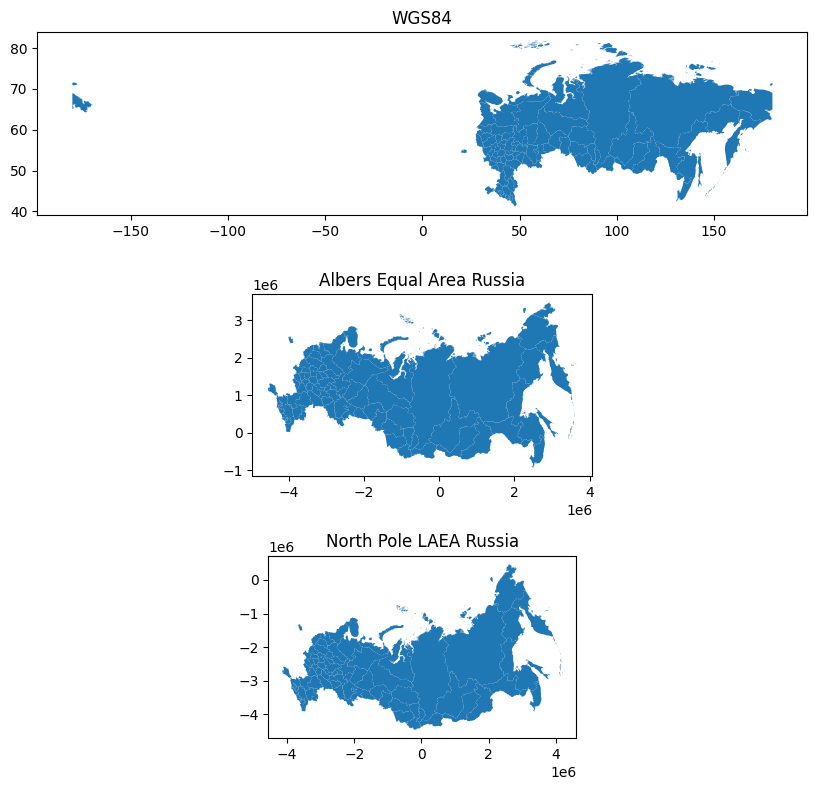

In [24]:
# Make subplots that are next to each other
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))

# Plot the data
gdf_wgs84.plot(ax=ax1)
new_gdf.plot(ax=ax2)
new2_gdf.plot(ax=ax3)

# Add title
ax1.set_title("WGS84")
ax2.set_title("Albers Equal Area Russia")
ax3.set_title("North Pole LAEA Russia")

# Remove empty white space around the plot
plt.tight_layout()

Как мы можем видеть, карты выглядят совершенно по-разному. Перепроецированные карты выглядит значительно лучше, особенно на Севере, где геометрия более реалистична и не так растянута, как в WGS84.

---

## Получение информации о CRS

При работе с географическими данными, полученными из разных источников, Вы, вероятно, столкнетесь с различными системами координат. Время от времени требуется возможность определять информацию CRS с нуля для данного набора данных, далее мы покажем несколько полезных приемов для работы с различными системами координат с использованием библиотеки `pyproj`. В предыдущем разделе мы увидели, как `geopandas` использует объект `pyproj.CRS` для хранения информации о системе отсчета координат. Фактически, эта же библиотека предоставляет множество полезных функций для работы с информацией CRS, и мы можем использовать объект/класс CRS, например, для простого анализа, определения и преобразования информации CRS. Далее мы импортируем класс `CRS` из библиотеки `pyproj` и инициализируем конкретную систему отсчета координат, используя метод .from_epsg() и код EPSG в качестве входных данных:

In [12]:
crs_object = CRS.from_epsg(3576)
crs_object

<Projected CRS: EPSG:3576>
Name: WGS 84 / North Pole LAEA Russia
Axis Info [cartesian]:
- X[south]: Easting (metre)
- Y[south]: Northing (metre)
Area of Use:
- name: Northern hemisphere - north of 45°N, including Arctic.
- bounds: (-180.0, 45.0, 180.0, 90.0)
Coordinate Operation:
- name: North Pole Lambert Azimuthal Equal Area (Russia)
- method: Lambert Azimuthal Equal Area
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Как вы можете видеть, очень легко инициализировать CRS с помощью `pyproj` с заданным кодом EPSG, и аналогичным образом вы можете инициализировать сотни других систем отсчета координат, изменив этот код. Результирующий объект CRS (переменная `crs_object`) содержит много информации о системе координат: название CRS (WGS 84 / North Pole LAEA Russia); область, в которой используется CRS (-180.0, 45.0, 180.0, 90.0); и датум (World Geodetic System 1984 ensemble). Также можем легко проанализировать эту информацию по отдельности следующим образом:

In [13]:
print("Name:", crs_object.name)
print("Coordinate system:", crs_object.coordinate_system)
print("Bounds:", crs_object.area_of_use.bounds)

Name: WGS 84 / North Pole LAEA Russia
Coordinate system: cartesian
Bounds: (-180.0, 45.0, 180.0, 90.0)


Можно легко экспортировать эту информацию CRS в различные форматы, такие как текст `WKT` или `Proj4`, или в код EPSG. Для этого мы можем использовать методы класса `CRS`, такие как `.to_wkt()`, `.to_proj4()` и `.to_epsg()` соответственно. Пример экспорта информации CRS в формат WKT:

In [14]:
crs_wkt = crs_object.to_wkt()
print(crs_wkt)

PROJCRS["WGS 84 / North Pole LAEA Russia",BASEGEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World Geodetic System 1984 (G730)"],MEMBER["World Geodetic System 1984 (G873)"],MEMBER["World Geodetic System 1984 (G1150)"],MEMBER["World Geodetic System 1984 (G1674)"],MEMBER["World Geodetic System 1984 (G1762)"],MEMBER["World Geodetic System 1984 (G2139)"],MEMBER["World Geodetic System 1984 (G2296)"],ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[2.0]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4326]],CONVERSION["North Pole Lambert Azimuthal Equal Area (Russia)",METHOD["Lambert Azimuthal Equal Area",ID["EPSG",9820]],PARAMETER["Latitude of natural origin",90,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude of natural origin",90,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["False easting",0,LENGTHUNIT["metre",1],I

Как мы видим, формат WKT содержит много информации. Как правило, например, файл `.prj` Shapefile содержит информацию в этом формате. Посмотрим, как из этого можно извлечь EPSG-код. Для этого мы сначала повторно инициализируем объект CRS из `WKT`, а затем анализируем код EPSG из CRS:

In [ ]:
# Получение EPSG кода из WKT
epsg = CRS(crs_wkt).to_epsg()
print(epsg)

3576


Иногда `to_epsg()` не в состоянии распознать код EPSG из WKT. Это может произойти, если в информации WKT отсутствуют какие-либо детали. К счастью, мы можем легко настроить минимальный уровень достоверности для сопоставления информации CRS и кода EPSG. Мы можем сделать это, настроив параметр `min_confidence` при вызове функции. По умолчанию уровень достоверности равен 70 %, но также можно установить более низкий порог достоверности, например, указав: `.to_epsg(min_confidence=25)`

---

## Определение CRS для GeoDataFrame

Одна из распространенных ситуаций, когда нужно задать CRS для ваших данных, - это создание нового фрейма геоданных с нуля. Далее мы сначала создадим новый фрейм геоданных с одной точкой без указания CRS:

In [15]:
# Создаем GeoDataFrame с одной точкой
point_gdf = gpd.GeoDataFrame({"geometry": Point(37.618893, 55.751497)}, index=[0])
print(point_gdf.crs)

None


Как мы видим, CRS отсутствует, что является проблемой, поскольку ГИС-системы не могут работать с такого рода наборами данных. Координаты нашей точки представлены в десятичных градусах, следовательно, CRS нашего GeoDataFrame должен быть WGS84. Мы можем определить CRS для наших данных несколькими различными способами, но один из подходов заключается в использовании метода `CRS.from_epsg()` из библиотеки `pyproj` и сохранении информации в `.crs` атрибуте GeoDataFrame:

In [16]:
point_gdf.crs = CRS.from_epsg(4326)
point_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Атрибут `.crs` был обновлен информацией о системе отсчета координат, и мы можем, например, при необходимости перепроецировать данные в другую CRS. Также можете указать CRS для данного GeoDataFrame, используя метод `.set_crs()`:

In [ ]:
point_gdf = point_gdf.set_crs(epsg=4326)
print(point_gdf.crs)

EPSG:4326


Естественно, вам не обязательно определять CRS отдельно после создания GeoDataFrame, можно указать информацию о CRS с параметром `crs` при создании GeoDataFrame следующим образом:

In [ ]:
# Создаем GeoDataFrame с одной точкой и задением CRS
point_gdf = gpd.GeoDataFrame(
    {"geometry": Point(37.618893, 55.751497)}, index=[0], crs="EPSG:4326"
)
point_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Построим нашу точку

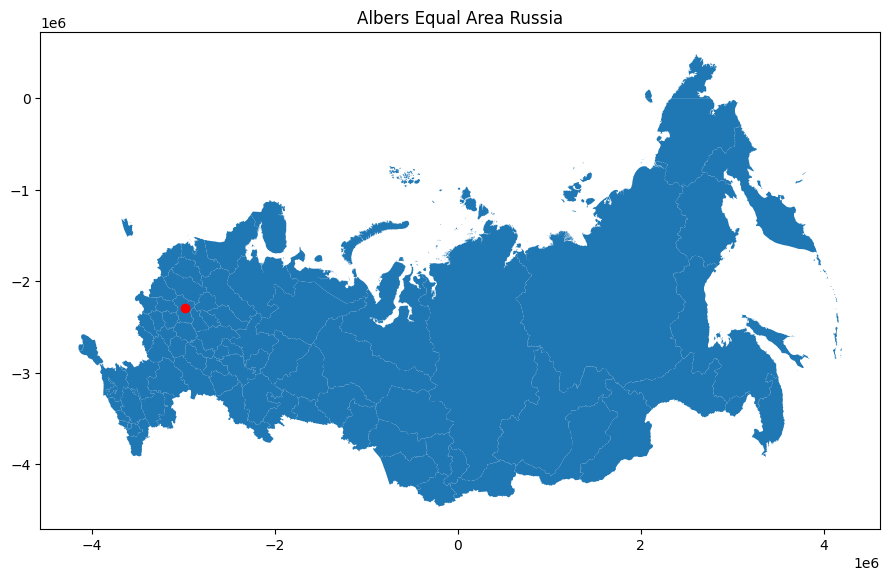

In [ ]:
# Change CRS to another
point_gdf = point_gdf.to_crs(epsg=new2_gdf.crs.to_epsg())

# Make subplots
fig, (ax) = plt.subplots(figsize=(9, 6))

# Plot the data
new2_gdf.plot(ax=ax)
point_gdf.plot(ax=ax, color='red')

# Add title
ax.set_title("Albers Equal Area Russia")

# Remove empty white space around the plot
plt.tight_layout()

# Индикатрисы Тиссо

Все картографические проекции искажают площадь, расстояние и угол. Задача картографа - выбрать наилучшую проекцию для данных и целей карты.

Следующий код использует `cartopy` для воспроизведения классического примера индикатрис Тиссо, который помогает наглядно представить искажения в различных глобальных проекциях.

На приведенных ниже графиках каждая окружность имеет равномерный радиус 500 км, и они равномерно распределены по земному шару через каждые 20° широты и долготы. Каждая проекция искажает эти окружности и их взаимное расположение.

In [ ]:
#Function to create cartopy plot with Tissot circles for input crs
def tissotplot(crs):
    #Create figure and axes
    fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize=(8,8))
    #Define positions of the circles, spaced every 20 degrees
    lons = range(-180, 180, 20)
    lats = range(-80, 81, 20)
    #Draw coastlines
    ax.coastlines()
    #Add gridlines
    gl = ax.gridlines(draw_labels=True, auto_inline=True, alpha=0.5, lw=0.5, linestyle=':')
    gl.xlocator = mticker.FixedLocator(lons)
    gl.ylocator = mticker.FixedLocator(lats)
    #Add tissot circles with 500 km radius
    ax.tissot(facecolor='orange', alpha=0.4, rad_km=500, lons=lons, lats=lats)
    #Title including projection name and proj string
    crs_name = str(crs).split(' ')[0].split('.')[-1][6:]
    ax.set_title(f'Name={crs_name}', fontsize=12)
    ax.set_global()

In [ ]:
#Define projecitons to plot
#Full list is here: https://scitools.org.uk/cartopy/docs/latest/reference/projections.html
crs_list = [ccrs.PlateCarree(), ccrs.LambertAzimuthalEqualArea(), ccrs.LambertCylindrical(),
            ccrs.Robinson(), ccrs.SouthPolarStereo(), ccrs.Sinusoidal(), ccrs.Orthographic(),
            ccrs.Mercator(), ccrs.TransverseMercator()]

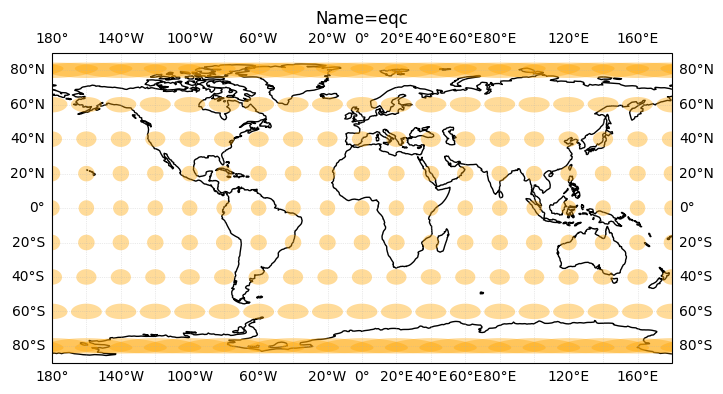

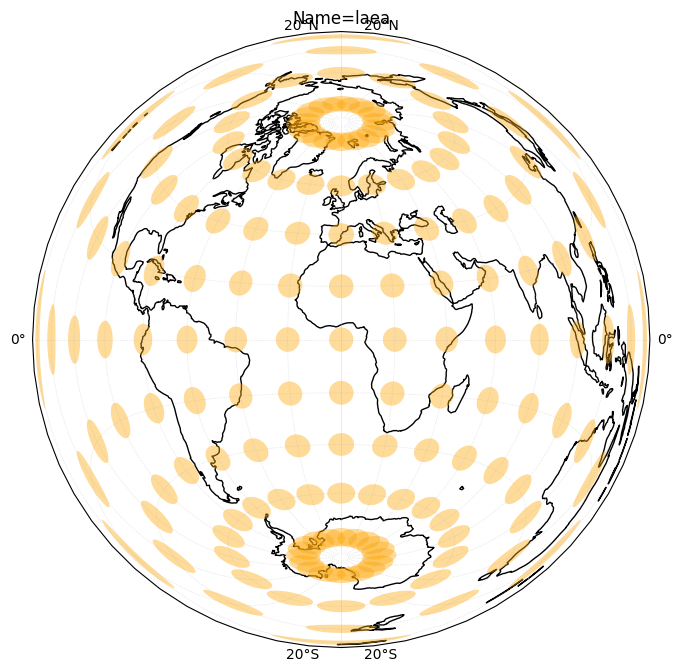

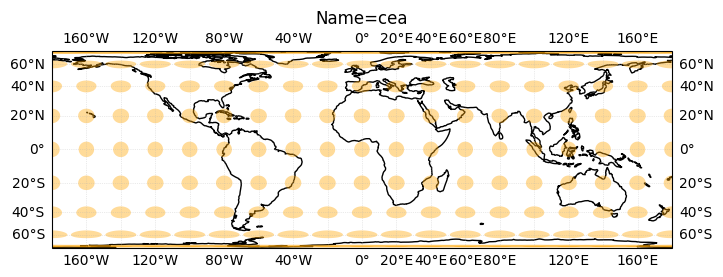

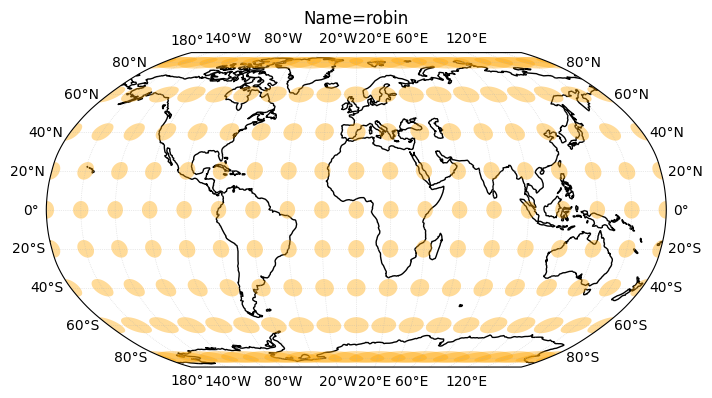

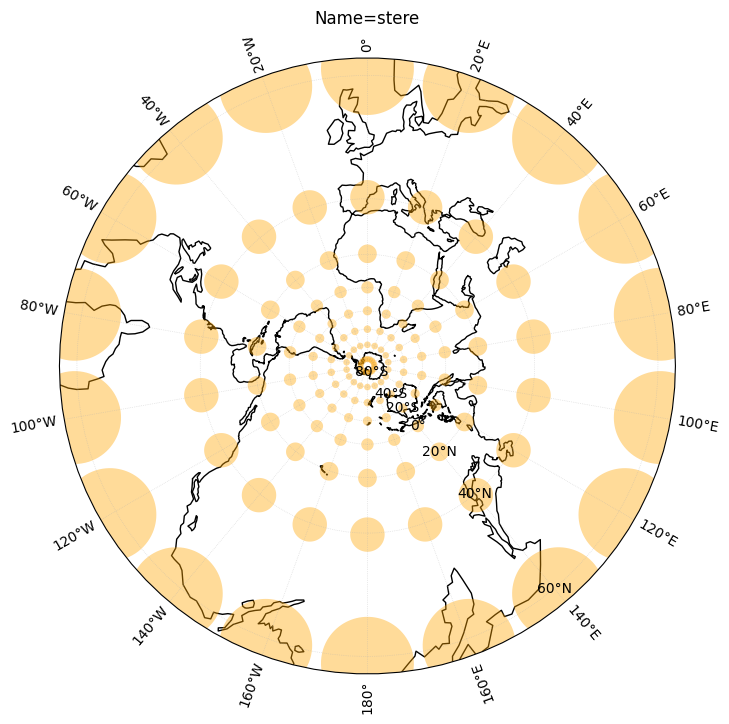

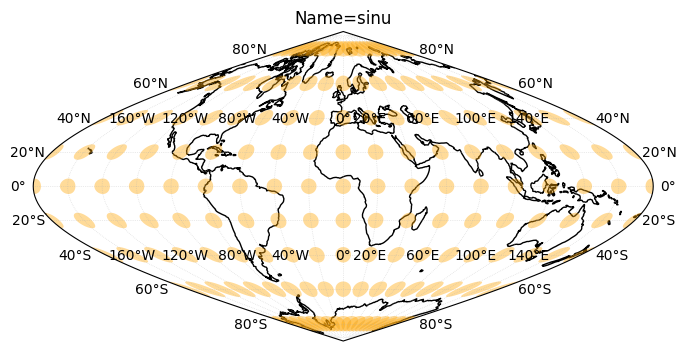

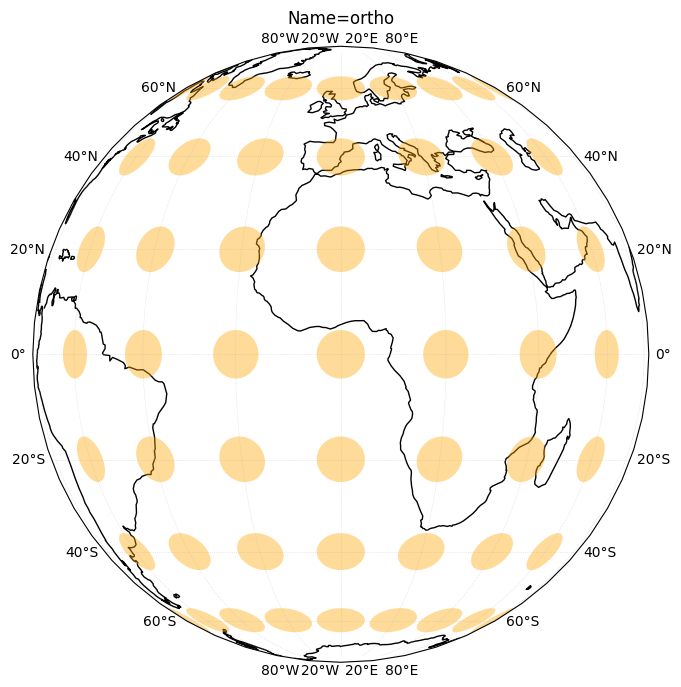

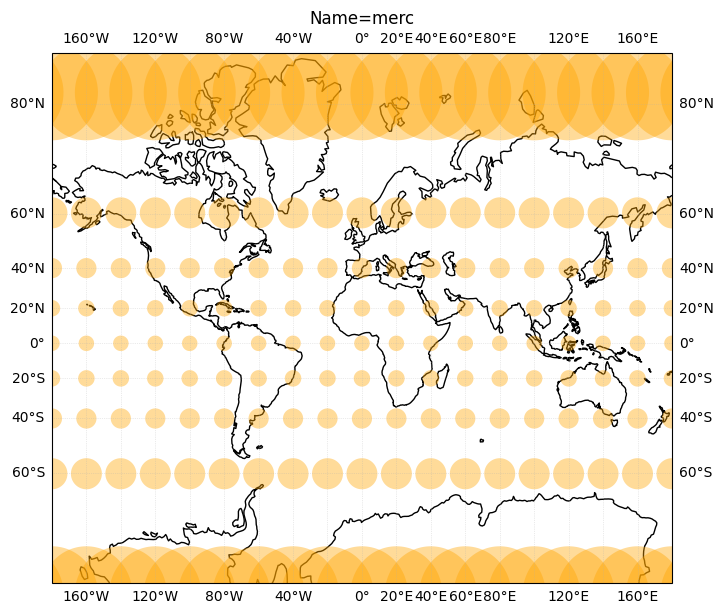

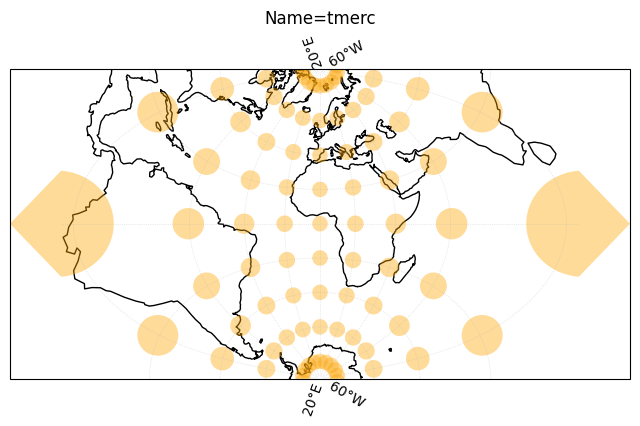

In [ ]:
for crs in crs_list:
    tissotplot(crs);